In [1]:
import sys
sys.path.append("/Users/zhanghangsheng/Documents/my_code/Cyber-Security-ML-Toolbox")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_csv('/Users/zhanghangsheng/others_code/可解释包/removal-explanations/data/brca_small.csv', index_col=0)
X = data.values[:, :-1]
Y = data.values[:, -1]
genes = data.columns.tolist()[:-1]
num_genes = len(genes)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=100, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=100, random_state=1)

# Normalize
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

print(X_val.shape)


(100, 100)


In [3]:
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

def fit_model(x, y, x_val, y_val):
    # Cross validate for C
    C_list = np.arange(0.1, 1.0, 0.05)
    best_loss = np.inf
    best_C = None

    for C in C_list:
        # Fit model
        model = LogisticRegression(C=C, penalty='l1', multi_class='multinomial',
                                   solver='saga', max_iter=20000)
        model.fit(x, y)

        # Calculate loss
        val_loss = log_loss(y_val, model.predict_proba(x_val))

        # See if best
        if val_loss < best_loss:
            best_loss = val_loss
            best_C = C
            
    # Train model with all data
    model = LogisticRegression(C=best_C, penalty='l1', multi_class='multinomial',
                               solver='saga', max_iter=10000)
    model.fit(np.concatenate((x, x_val), axis=0),
              np.concatenate((y, y_val), axis=0))
    
    return model

# Train model
original_model = fit_model(X_train, Y_train, X_val, Y_val)

# Train surrogate model

# - A surrogate model mimics the original model's predictions when features are held out.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, BatchSampler
from csmt.Interpretability.rexplain.torch import MaskLayer1d
from copy import deepcopy
import matplotlib.pyplot as plt

# Custom loss function
class CELoss(nn.Module):
    '''Cross entropy loss for distributional targets. Expects logits.'''
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        return - torch.mean(
            torch.sum(pred.log_softmax(dim=1) * target, dim=1))
# Prepare device
device = torch.device('cpu')

# Prepare training data
X_model = torch.tensor(X_train, dtype=torch.float32)
Y_model = torch.tensor(original_model.predict_proba(X_train),
                       dtype=torch.float32)

# Prepare validation data
Y_val_surrogate = torch.tensor(original_model.predict_proba(X_val).repeat(1000, 0),
                               dtype=torch.float32)
X_val_surrogate = torch.tensor(X_val.repeat(1000, 0), dtype=torch.float32)

# Random subsets
S_val = torch.ones(X_val_surrogate.shape)
num_included = np.random.choice(num_genes + 1, size=len(S_val))
for i in range(len(S_val)):
    S_val[i, num_included[i]:] = 0
    S_val[i] = S_val[i, torch.randperm(num_genes)]

# Create dataset iterator
val_set = TensorDataset(X_val_surrogate, Y_val_surrogate, S_val)
val_loader = DataLoader(val_set, batch_size=25000)

def validate(model):
    '''Measure performance on validation set.'''
    with torch.no_grad():
        # Setup
        mean_loss = 0
        N = 0

        # Iterate over validation set
        for x, y, S in val_loader:
            x = x.to(device)
            y = y.to(device)
            S = S.to(device)
            pred = model((x, S))
            loss = loss_fn(pred, y)
            N += len(x)
            mean_loss += len(x) * (loss - mean_loss) / N

    return mean_loss

In [4]:


# Set up model
model = nn.Sequential(
    MaskLayer1d(value=0),
    nn.Linear(2 * num_genes, 64),
    nn.ELU(inplace=True),
    nn.Linear(64, 64),
    nn.ELU(inplace=True),
    nn.Linear(64, 4)).to(device)

# Training parameters
lr = 1e-3
nepochs = 50
early_stop_epochs = 10

# Loss function
loss_fn = CELoss()
loss_list = []

for mbsize in (32, 128):
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up data loaders
    train_set = TensorDataset(X_model, Y_model)
    random_sampler = RandomSampler(
        train_set, replacement=True,
        num_samples=int(np.ceil(len(X_model) / mbsize))*mbsize)
    batch_sampler = BatchSampler(random_sampler, batch_size=mbsize, drop_last=True)
    train_loader = DataLoader(train_set, batch_sampler=batch_sampler)

    # For saving best model
    min_epoch = 0
    best_model = deepcopy(model)
    best_epoch_loss = validate(model).item()
    best_epoch = 0

    # Begin training
    for epoch in range(nepochs):
        for i, (x, y) in enumerate(train_loader):
            # Prepare data
            x = x.to(device)
            y = y.to(device)

            # Generate subset
            S = torch.ones(mbsize, num_genes, dtype=torch.float32, device=device)
            num_included = np.random.choice(num_genes + 1, size=mbsize)
            for j in range(mbsize):
                S[j, num_included[j]:] = 0
                S[j] = S[j, torch.randperm(num_genes)]

            # Make predictions
            pred = model((x, S))
            loss = loss_fn(pred, y)

            # Optimizer step
            loss.backward()
            optimizer.step()
            model.zero_grad()

        # End of epoch progress message
        val_loss = validate(model).item()
        loss_list.append(val_loss)
        print('----- Epoch = {} -----'.format(epoch + 1))
        print('Val loss = {:.4f}'.format(val_loss))
        print('')

        # Check if best model
        if epoch >= min_epoch:
            if val_loss < best_epoch_loss:
                best_epoch_loss = val_loss
                best_model = deepcopy(model)
                best_epoch = epoch
                print('New best epoch, val loss = {:.4f}'.format(val_loss))
                print('')
            else:
                # Check for early stopping
                if epoch - best_epoch == early_stop_epochs:
                    print('Stopping early')
                    break

    model = best_model


----- Epoch = 1 -----
Val loss = 1.0775

New best epoch, val loss = 1.0775

----- Epoch = 2 -----
Val loss = 0.9500

New best epoch, val loss = 0.9500

----- Epoch = 3 -----
Val loss = 0.8432

New best epoch, val loss = 0.8432

----- Epoch = 4 -----
Val loss = 0.7847

New best epoch, val loss = 0.7847

----- Epoch = 5 -----
Val loss = 0.7519

New best epoch, val loss = 0.7519

----- Epoch = 6 -----
Val loss = 0.7298

New best epoch, val loss = 0.7298

----- Epoch = 7 -----
Val loss = 0.7207

New best epoch, val loss = 0.7207

----- Epoch = 8 -----
Val loss = 0.7048

New best epoch, val loss = 0.7048

----- Epoch = 9 -----
Val loss = 0.6999

New best epoch, val loss = 0.6999

----- Epoch = 10 -----
Val loss = 0.7013

----- Epoch = 11 -----
Val loss = 0.6915

New best epoch, val loss = 0.6915

----- Epoch = 12 -----
Val loss = 0.6845

New best epoch, val loss = 0.6845

----- Epoch = 13 -----
Val loss = 0.6822

New best epoch, val loss = 0.6822

----- Epoch = 14 -----
Val loss = 0.6902

-

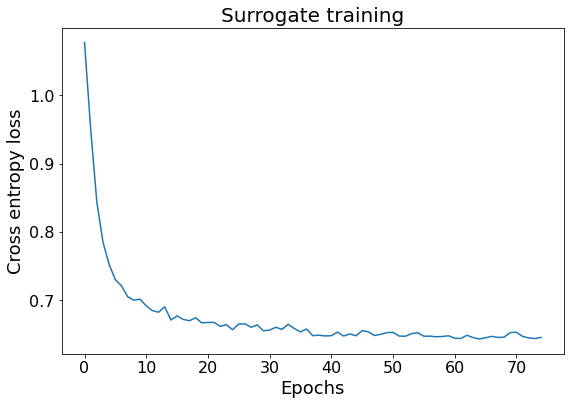

In [5]:
# Plot loss during training
plt.figure(figsize=(9, 6))
plt.plot(loss_list)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Cross entropy loss', fontsize=18)
plt.tick_params(labelsize=16)
plt.title('Surrogate training', fontsize=20)
plt.show()

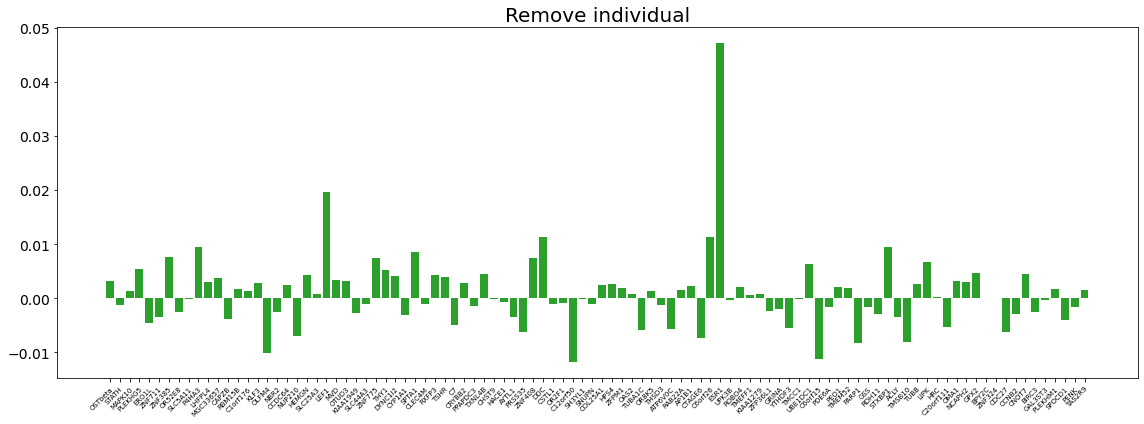

In [10]:
from rexplain import removal, behavior, summary
from rexplain.utils import crossentropyloss

# Make model callable with numpy input
model_lam = lambda x, S: torch.softmax(
    model((torch.tensor(x, dtype=torch.float32, device=device),
           torch.tensor(S, dtype=torch.float32, device=device))),
    dim=1).cpu().data.numpy()

# Model extension
conditional_extension = removal.ConditionalSupervisedExtension(model_lam)

# Cooperative game
game = behavior.DatasetLossGame(conditional_extension, X_test, Y_test, crossentropyloss)

# Summary technique
remove_attr = summary.RemoveIndividual(game)
plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(remove_attr)), remove_attr, color='tab:green')
plt.tick_params(labelsize=14)
plt.xticks(np.arange(len(remove_attr)), genes,
           rotation=45, rotation_mode='anchor',
           ha='right', fontsize=7)
plt.title('Remove individual', fontsize=20)
plt.tight_layout()
plt.show()

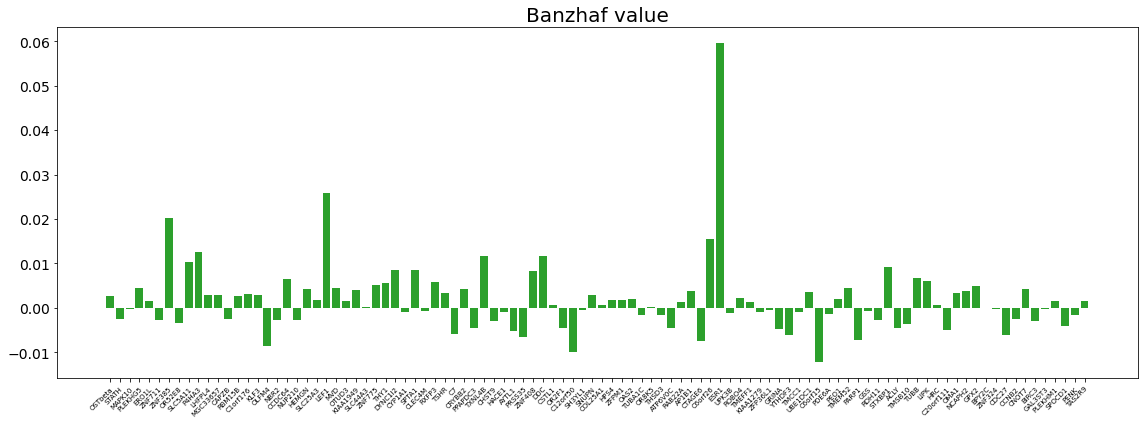

In [11]:
# Summary technique
banzhaf_attr = summary.BanzhafValue(game, thresh=0.01)

plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(banzhaf_attr)), banzhaf_attr, color='tab:green')
plt.tick_params(labelsize=14)
plt.xticks(np.arange(len(banzhaf_attr)), genes,
           rotation=45, rotation_mode='anchor',
           ha='right', fontsize=7)
plt.title('Banzhaf value', fontsize=20)
plt.tight_layout()
plt.show()

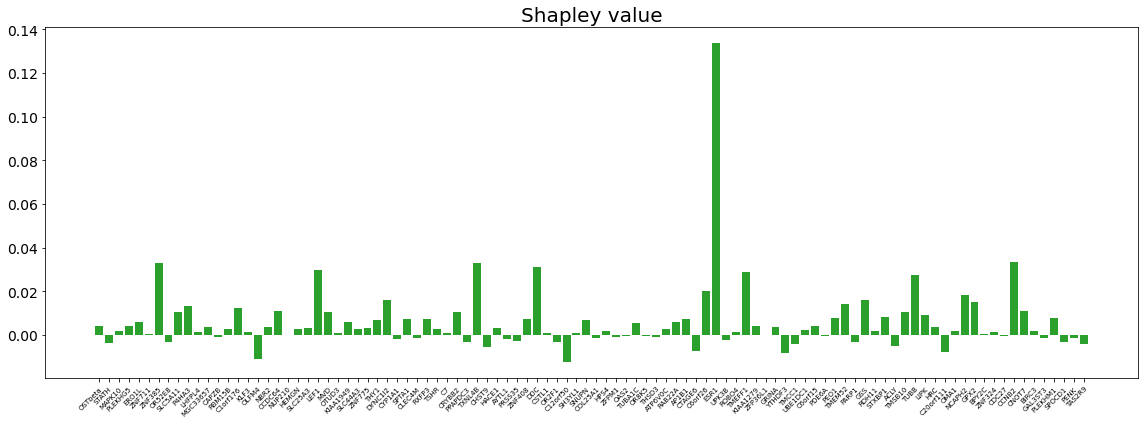

In [12]:
# Summary technique
shapley_attr = summary.ShapleyValue(game, thresh=0.01)

plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(shapley_attr)), shapley_attr, color='tab:green')
plt.tick_params(labelsize=14)
plt.xticks(np.arange(len(shapley_attr)), genes,
           rotation=45, rotation_mode='anchor',
           ha='right', fontsize=7)
plt.title('Shapley value', fontsize=20)
plt.tight_layout()
plt.show()

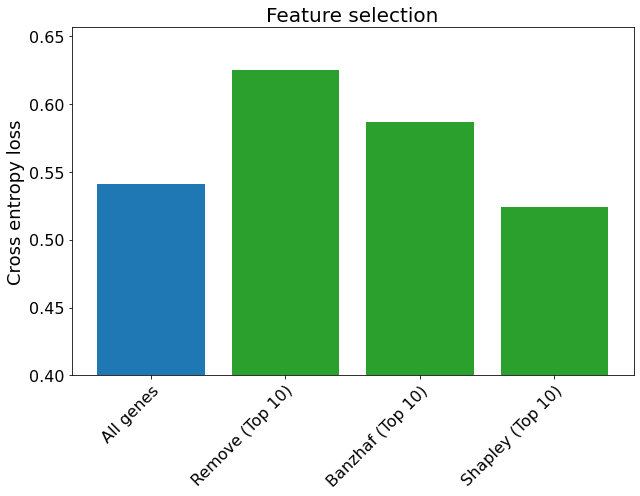

In [13]:
# Setup
attr_list = [remove_attr, banzhaf_attr, shapley_attr]
attr_names = ['Remove', 'Banzhaf', 'Shapley']
num = 10
loss_list = []

# Train small models
for attr in attr_list:
    # Filter for important genes
    inds = np.argsort(attr)[-num:]
    X_train_small = X_train[:, inds]
    X_val_small = X_val[:, inds]
    X_test_small = X_test[:, inds]

    # Train model
    small_model = fit_model(X_train_small, Y_train, X_val_small, Y_val)
    loss = log_loss(Y_test, small_model.predict_proba(X_test_small))
    loss_list.append(loss)
    
plt.figure(figsize=(9, 7))

plt.bar(np.arange(len(attr_list) + 1),
        [log_loss(Y_test, original_model.predict_proba(X_test))] + loss_list,
        color=['C0'] + ['tab:green' for _ in attr_list])
plt.xticks(np.arange(len(attr_list) + 1),
           ['All genes'] + ['{} (Top {})'.format(name, num) for name in attr_names],
           rotation=45, rotation_mode='anchor', ha='right')
plt.ylabel('Cross entropy loss', fontsize=18)
plt.title('Feature selection', fontsize=20)
plt.tick_params(labelsize=16)
plt.ylim(0.4, None)

plt.tight_layout()
plt.show()